# CSCI 5922 (Spring 2020) Final Project
name: Timothy Mason
***
Music Genre classification using a CRNN as described in the paper blah, blah, blah...

todo: fill in citations and flesh out overview

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm      # for easy and attractive progress bars

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

## Functions for importing data

In [14]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories={"artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
                                      "analysis_sample_rate", # sample rate (Hz) for the analysis
                                      "duration",             # length of the piece (seconds)
                                      "tempo",                # tempo of the piece (avg beats per minute)
                                      "beats_start",          # list of time markers (seconds) for beats
                                      "bars_start",           # list of time markers (seconds) for bars
                                      "tatums_start",         # "list of tatum markers, in seconds. Tatums 
                                                              # represent the lowest regular pulse train that
                                                              # a listener intuitively infers from the timing
                                                              # of perceived musical events (segments)."
                                      "segments_start",       # list of time markers (seconds) for segments
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     }, 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    categories.add('track_id')   # categories is type "set", so no worry about duplicates

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading 10k Subset of MSD"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            d[c] = t
        h5file.close()
        data.append(d)
    return pd.DataFrame(data).set_index('track_id')

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the data from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset
    """
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading last.fm tags"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            j = json.load(json_data)
            if j['tags']:      # skip tag-less entries
                data.append(j)
            
    return pd.DataFrame(data).set_index('track_id')


## Load and merge the datasets

In [15]:
df = hdf_tree_to_dataframe().merge(right=json_tree_to_dataframe(),
                                   how='inner',    # keep only the tracks which are present in both datasets
                                   left_on=('track_id','title','artist_name'), # stringent match criterea
                                   right_on=('track_id','title','artist'),
                                  )

Loading last.fm tags: 100%|██████████| 9330/9330 [00:04<00:00, 2034.17it/s]


### Sample Data Visualization

Because it looks cool!

### TRAQDWW12903CF4274: "Handel: Alcina: Tornami a vagheggiar" by *Joan Sutherland* on *Joan Sutherland*
[['classic', '100'], ['instrumental', '100'], ['romantic', '100'], ['soprano', '80'], ['opera', '60'], ['aria', '60'], ['Classical', '40'], ['gesang', '40'], ['composers', '20'], ['fave raves', '20'], ['soprano aria', '20'], ['classic lift', '20'], ['Nicolas Gombert', '20'], ['delicious Handel', '20'], ['slgdmclsscl', '20']]

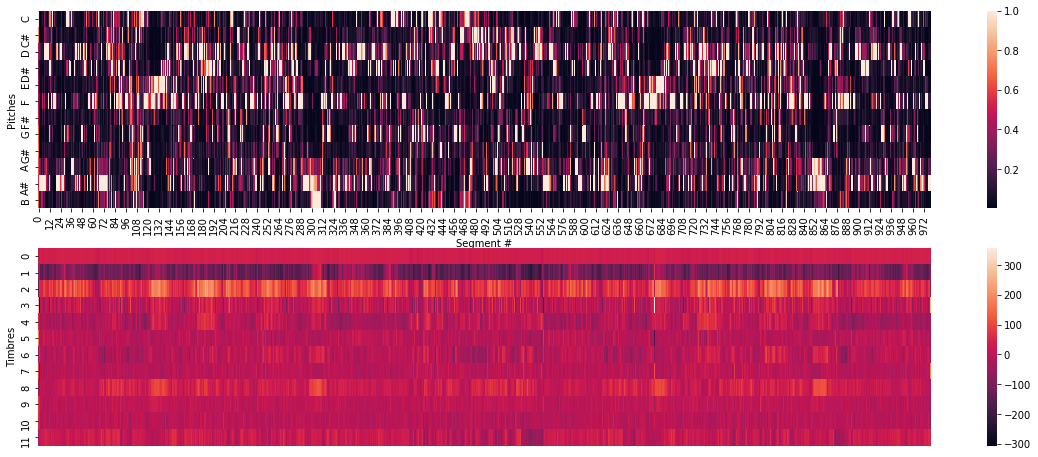

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import random

%matplotlib inline

x = random.randint(0,df.shape[0]-2)

for i in df.index[x:x+1]:
    name = f'### {i:2}: "{df.title[i]}" by *{df.artist_name[i]}* on *{df.release[i]}*'
    if df.year[i] != 0:
        name += f', released {df.year[i]}'
    name += '\n'
    name += f'{df.tags[i]}'
    display(Markdown(name))
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(20,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

In [ ]:

xticklabels